In [1]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, deepSkip, localSkip
# import parallel_euler as arch1
import torch
from torch import nn
import l63, glob, count_params
import config as cf
from matplotlib.text import Text
from matplotlib import ticker
from matplotlib.collections import PolyCollection
from scipy.stats import ks_2samp 
import count_params as cp
import wasserstein as ws
import json

dynamical_system = 'L63'
root = f'../data/{dynamical_system}'
# ut.collect_beta();

**Violin plot of VPT**

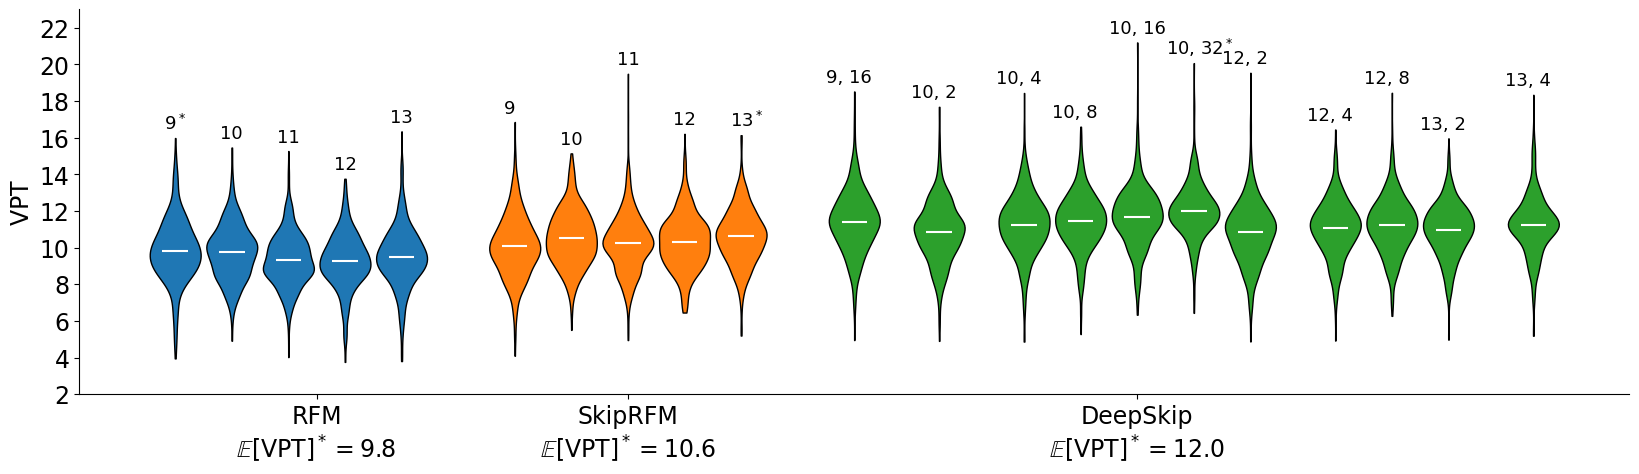

In [14]:
config = 'config_1_s'
architectures = {'config_0':['SkipRFM', 'DeepSkip'], 'config_1_s':['RFM', 'SkipRFM', 'DeepSkip'], 'config_0_s':['SkipRFM', 'DeepSkip']}
clrs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = {'config_0': clrs, 'config_1_s': clrs, 'config_0_s': clrs}
x_pos = {'config_0':[2, 10], 'config_1_s':[2.5, 8, 17], 'config_0_s':[2, 10]}
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
smoothing_window = 5
m, n = 0, 0
params = []
best = []
vpts = []
cs = []
positions = []
summary = ut.summary(dynamical_system)[config]
for i, architecture in enumerate(architectures[config]):
    df_data = {'#params': [], 'vpt': []}
    subfolders = [x for x in glob.glob(f'{root}/{config}/{architecture}/*') if not 'beta' in x]
    for x in subfolders:
        if ut.get_arch(x) == []:
            subfolders.remove(x)
    sizes = [[x[2], x[3]] for x in list(map(ut.get_arch, subfolders))]
    means = [pd.read_csv(f'{x}/batch_data.csv')['tau_f_nmse'].mean() for x in subfolders]
    subfolders = [x for _, x in sorted(zip(sizes, subfolders))]
    n += len(subfolders)-1 
    best += [np.array(list(summary[architecture].values()))[:, 0].max()]
    curr_D_r = 2**9
    for subfolder in subfolders:
        if not 'beta' in subfolder:
            arch = ut.get_arch(subfolder)
            if arch[2] == 16384:
                continue
            if arch[0] == "DeepSkip" and (arch[2] == 2048 or arch[3] == 1):
                continue
            # print(arch)
            data = pd.read_csv(f'{subfolder}/batch_data.csv')
            vpt = data['tau_f_nmse']
            vpts.append(vpt)
            p = np.log10(arch[-1])
            df_data['#params'] += [m] * len(vpt)
            df_data['vpt'] += vpt.to_list()
            params += [p]
            if architecture == "RFM" or architecture == "SkipRFM":
                text = r"{}".format(int(np.log2(arch[2])))
            else:
                text = r"{}, {}".format(int(np.log2(arch[2])), arch[3])
            if vpt.mean() == best[-1]:
                text += r'$^*$'
            if "Deep" not in arch[0]:
                ax.text(m+0.8-1, vpt.max()+0.5, text, fontsize=13)
            else:
                ax.text(m+0.5-1, vpt.max()+0.5, text, fontsize=13)
            positions += [m]
            if "Deep" in arch[0]:
                if arch[2] > curr_D_r:
                    curr_D_r = arch[2] + 0
                    m += 0.5
            m += 1
            cs.append(colors[config][i])
    df = pd.DataFrame(df_data)
    m += 1
    
    # sns.violinplot(data=df, x="#params", y="vpt", ax=ax, color=colors[config][i])
    # sns.pointplot(data=df, x="#params", y="vpt", ax=ax, color=colors[config][i], estimator=np.mean, linewidth=1)

violin_parts = ax.violinplot(vpts, positions=positions, showextrema=False, showmeans=True, side="both", widths=0.9)#"silverman")
for k, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(cs[k])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
violin_parts['cmeans'].set_color('white')

for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('black')
ax.set_xticks(x_pos[config], labels=[architectures[config][i] + '\n' + r'$\mathbb{E}[\rm VPT]^*=$' + f'{best[i]:.1f}' for i in range(len(architectures[config]))])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'')
ax.set_ylabel(r'${\rm VPT}$', fontsize=17)
ax.set_ylim((2, 23))
ax.set_yticks(np.arange(2, 23, 2))
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
plt.savefig(f'../data/plots/final/{dynamical_system}-{config}-vpt-violin.pdf', bbox_inches='tight', dpi=300)

**Does skip connection underperform for large dt?**

4.829916000000001 4.821362 9.588306000000001


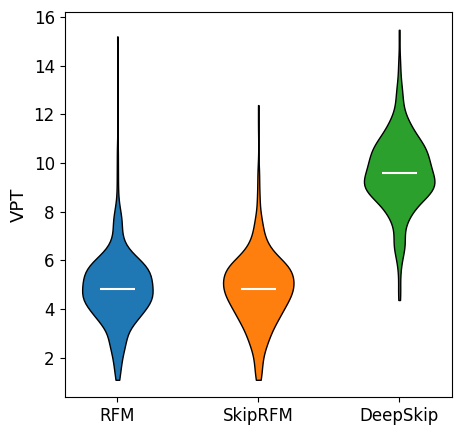

In [188]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# data1 = pd.read_csv(f"{folder}/config_2_s/RFM/D_r-16384_B-1/batch_data.csv")
# data2 = pd.read_csv(f"{folder}/config_2_s/SkipRFM/D_r-16384_B-1/batch_data.csv")
# data3 = pd.read_csv(f"{folder}/config_2_s/DeepSkip/D_r-1024_B-16/batch_data.csv")
# filename = '../data/plots/L63-dt-025-vpt.png'

data1 = pd.read_csv(f"{root}/config_3_s/RFM/D_r-16384_B-1/batch_data.csv")
data2 = pd.read_csv(f"{root}/config_3_s/SkipRFM/D_r-16384_B-1/batch_data.csv")
data3 = pd.read_csv(f"{root}/config_3_s/DeepSkip/D_r-716_B-16/batch_data.csv")
filename = '../data/plots/final/L63-dt-01-vpt.pdf'

data = {"vpt": [], "pos": []}
data['vpt'] +=  data1['tau_f_nmse'].to_list()
data['pos'] +=  [1] * len(data1['tau_f_nmse'])
data['vpt'] +=  data2['tau_f_nmse'].to_list()
data['pos'] +=  [1.1] * len(data2['tau_f_nmse'])
data['vpt'] +=  data3['tau_f_nmse'].to_list()
data['pos'] +=  [1.2] * len(data3['tau_f_nmse'])
print(data1['tau_f_nmse'].mean(), data2['tau_f_nmse'].mean(), data3['tau_f_nmse'].mean())
# sns.violinplot(data, x="pos", y="vpt", ax=ax)
violin_parts = ax.violinplot([data1['tau_f_nmse'], data2['tau_f_nmse'], data3['tau_f_nmse']], showextrema=False, showmeans=True,\
                              side="both")
for k, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(clrs[k])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
violin_parts['cmeans'].set_color('white')
for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('black')

# ax.violinplot(data2['tau_f_nmse'], [1]*500)
ax.set_xticks([1, 2, 3], ['RFM', 'SkipRFM', 'DeepSkip'], fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('VPT', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(filename, bbox_inches="tight", dpi=300)

**Effect of depth**

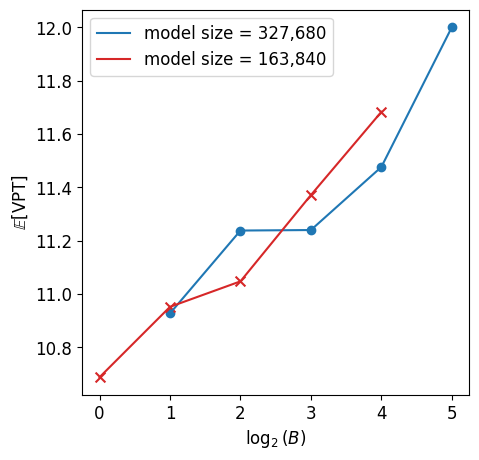

In [217]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
DrBs1 = [(16384, 2), (8192, 4), (4096, 8), (2048, 16), (1024, 32)]
DrBs2 = [(16384, 1), (8192, 2), (4096, 4), (2048, 8), (1024, 16)]
data_folders1 = [f'{root}/config_1_s/DeepSkip/D_r-{D_r}_B-{B}' for D_r, B in DrBs1]
data_folders2 = [f'{root}/config_1_s/DeepSkip/D_r-{D_r}_B-{B}' for D_r, B in DrBs2]

filename = '../data/plots/final/L63-depth.pdf'

x, y = [], []
for i, folder in enumerate(data_folders1):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs1[i][1]))
    y.append(data['tau_f_nmse'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[0])
ax.plot(x, y, c=clrs[0], label='model size = 327,680')

x, y = [], []
for i, folder in enumerate(data_folders2):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs2[i][1]))
    y.append(data['tau_f_nmse'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[3], marker='x', s=50)
ax.plot(x, y, c=clrs[3], label='model size = 163,840')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\log_2(B)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$', fontsize=12)
plt.savefig(filename, bbox_inches="tight", dpi=300)

**Climate plot**

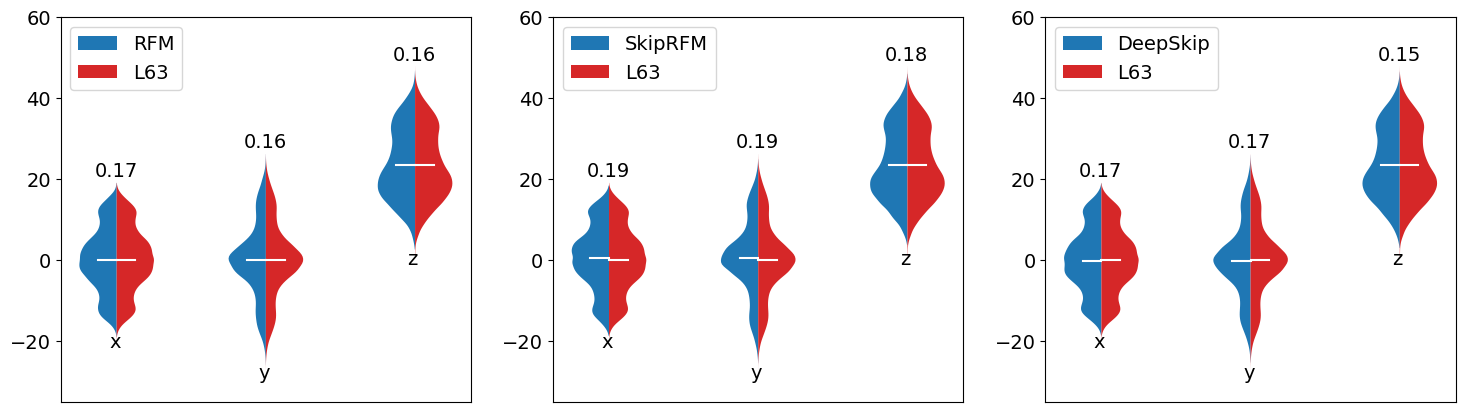

In [198]:
fig = plt.figure(figsize=(18, 5))
axs = [fig.add_subplot(1,3, i+1) for i in range(3)]
archs = ['RFM', 'SkipRFM', 'DeepSkip']
coords = ['x', 'y', 'z']
folders = [f'{root}/config_1_s/attractor' for arch in archs]
reconstruction = [np.load(f'{folders[i]}/{archs[i]}/attractor.npy') for i in range(3)]
original = [np.load(f'{folders[i]}/train.npy')[:, :reconstruction[i].shape[1]] for i in range(3)]
w2_data = pd.read_csv(f'{root}/{dynamical_system}-w2.csv')

# w2_flat = {}
for i, arch in enumerate(archs):
    vp_left = axs[i].violinplot(reconstruction[i].T, showextrema=False, showmeans=True, side="low")
    vp_right = axs[i].violinplot(original[i].T, showextrema=False, showmeans=True, side="high")
    # null_left = sns.kdeplot(reconstruction[i].T)
    
    for vp in [vp_left, vp_right]:
        vp['cmeans'].set_colors('white')
        for k, pc in enumerate(vp['bodies']):
            pc.set_alpha(1.0)
            if vp==vp_left:
                    pc.set_facecolor(clrs[0])
                    # vp['cmeans'].set_colors(clrs[0])
            else:
                pc.set_facecolor(clrs[3])
                # vp['cmeans'].set_colors(clrs[3])
    top = np.max(list(zip(reconstruction[i].max(axis=1), original[i].max(axis=1))), axis=1)
    bottom = np.min(list(zip(reconstruction[i].min(axis=1), original[i].min(axis=1))), axis=1)

    for j in range(3):
        axs[i].text(j+0.95, bottom[j]-2.0, coords[j], fontsize=14)
        idx1 = torch.randperm(len(original[i][j]))[:10000]
        idx2 = torch.randperm(len(reconstruction[i][j]))[:10000]
        # w2 = float(ws.sinkhorn_div(torch.tensor(original[i][j])[idx1].reshape(-1, 1), torch.tensor(reconstruction[i][j])[idx1].reshape(-1, 1)))
        w2 = w2_flat[f'{arch}-{j}']**0.5 
        # ks = ks_2samp(original[i][j], reconstruction[i][j])
        # l2 = ut.l2_kde(original[i][j], reconstruction[i][j])
        axs[i].text(j+0.85, top[j]+1.5, f"{w2:.2f}", fontsize=14)
    axs[i].set_ylim((-35, 60))
    axs[i].set_xticks([])
    # w2 = w2_data[w2_data['architecture']==archs[i]].iloc[0]["w2"]
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].legend([vp_left['bodies'][0], vp_right['bodies'][0]], [archs[i], "L63"], fontsize=14)
    plt.savefig(f'../data/plots/final/{dynamical_system}-climate.pdf', bbox_inches='tight', dpi=300)


**L63 trajectory**

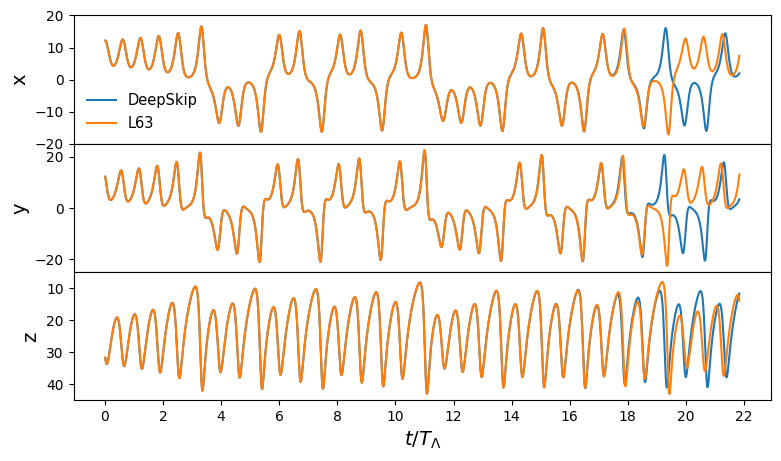

In [14]:
def waterfall(truth, prediction, filename=None, **tau_f_kwargs):
    _, m = truth.shape
    t = np.linspace(1, m, num=m) * tau_f_kwargs['dt'] / tau_f_kwargs['Lyapunov_time']
    y_lims = [(-20, 20), (-25, 25), (45, 5)]
    vars = ['x', 'y', 'z']
    fig = plt.figure(figsize=(9, 5))
    axs = [fig.add_subplot(3, 1, i+1) for i in range(3)]
    

    
    axs[-1].set_xlabel(r'$t/T_{\Lambda}$', fontsize=14)
    for i in range(3):
        axs[i].plot(t, prediction[i, :], label='DeepSkip')

    for i in range(3):
        axs[i].plot(t, truth[i, :], label='L63')
        axs[i].set_ylabel(vars[i], fontsize=14)
        axs[i].set_xticks(range(0, 24, 2), range(0, 24, 2))
        axs[i].set_ylim(y_lims[i])
        if i != 2:
            axs[i].set_xticks([])
    axs[0].legend(frameon=False, fontsize=10.5, loc='lower left')
    fig.subplots_adjust(hspace=0.0)
    if filename is not None:
        plt.savefig(f'../data/plots/final/{filename}.pdf', bbox_inches='tight', dpi=300)
    
truth = np.load(f'{root}/config_1_s/attractor/truth.npy')[:, :2400]
prediction = np.load(f'{root}/config_1_s/attractor/prediction.npy')[:, :2400]
tau_f_kwargs = {"error_threshold": 0.09, "dt": 0.01, "Lyapunov_time": 1/0.91}
waterfall(truth, prediction, filename='L63-forecast', **tau_f_kwargs)

**Temporal autocorrelation**

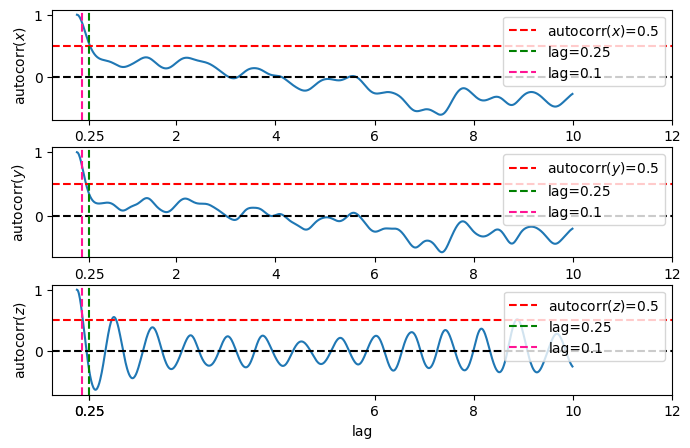

In [59]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

n = 2000
u = np.load(f'{folder}/train.npy')[:, :n]
dt = 0.01
lags = np.arange(n//2)
ax1.plot(lags*dt, ut.autocorr(u[0], lags))
ax1.axhline(y=0, c='black', linestyle='dashed')
ax1.axhline(y=0.5, c='red', linestyle='dashed', label=r'autocorr($x$)=0.5')
ax1.axvline(x=0.25, c='green', linestyle='dashed', label=r'lag=0.25')
ax1.axvline(x=0.1, c='deeppink', linestyle='dashed', label=r'lag=0.1')
ax1.set_ylabel(r'autocorr($x$)')
ticks, labels = list(ax1.get_xticks())[2:], list(ax1.get_xticklabels())[2:]
ticks.append(0.25)
labels.append(Text(0.25, 0, '0.25'))
ax1.set_xticks(ticks, labels)
ax1.legend()

ax2.plot(lags*dt, ut.autocorr(u[1], lags))
ax2.axhline(y=0, c='black', linestyle='dashed')
ax2.axhline(y=0.5, c='red', linestyle='dashed', label=r'autocorr($y$)=0.5')
ax2.axvline(x=0.25, c='green', linestyle='dashed', label=r'lag=0.25')
ax2.axvline(x=0.1, c='deeppink', linestyle='dashed', label=r'lag=0.1')
ax2.set_ylabel(r'autocorr($y$)')
ticks, labels = list(ax2.get_xticks())[2:], list(ax2.get_xticklabels())[2:]
ticks.append(0.25)
labels.append(Text(0.25, 0, '0.25'))
ax2.set_xticks(ticks, labels)
ax2.legend()

ax3.plot(lags*dt, ut.autocorr(u[2], lags))
ax3.axhline(y=0, c='black', linestyle='dashed')
ax3.axhline(y=0.5, c='red', linestyle='dashed', label=r'autocorr($z$)=0.5')
ax3.axvline(x=0.25, c='green', linestyle='dashed', label=r'lag=0.25')
ax3.axvline(x=0.1, c='deeppink', linestyle='dashed', label=r'lag=0.1')
ax3.set_ylabel(r'autocorr($z$)')
ticks, labels = list(ax2.get_xticks())[2:], list(ax2.get_xticklabels())[2:]
ticks.append(0.25)
labels.append(Text(0.25, 0, '0.25'))
ax3.set_xticks(ticks, labels)
ax3.legend()
ax3.set_xlabel('lag')
fig.subplots_adjust(hspace=0.25)
plt.savefig(f'../data/plots/{dynamical_system}-temporal-autocorr.png', bbox_inches='tight', dpi=1200)

In [35]:
from scipy.stats import gaussian_kde as kde

data1 = np.random.normal(size=(40, 1)).T
data2 = np.random.normal(size=(40, 1)).T
pdf1 = kde(data1)
pdf2 = kde(data2)
N = 500
x = np.linspace(data1.min(), data1.max(), num=N, endpoint=False)
delx = (data1.max() - data1.min()) / N
y1 = pdf1.evaluate(x)
y2 = pdf2.evaluate(x)
r = np.sqrt((1./N)*((y1-y2)**2).sum()*delx)
print(r)

0.005102493227482073


In [36]:
np.arange(1, 9, 0.001).shape

(8000,)

In [37]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U codeium-jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3
    Uninstalling pip-23.3:
      Successfully uninstalled pip-23.3


In [105]:
cp.LocalDeepSkip(40, 1024, 16, 2, 2)

245760

In [193]:
with open(f'{root}/w2-flat.json', 'w') as f:
    json.dump(w2_flat, f, indent=4)

In [213]:
d = np.sqrt((((truth - prediction)/truth.std(axis=1)[:, np.newaxis])**2).mean(axis=0))

In [211]:
* 0.91 * 0.01

17.7814

In [215]:
np.argmax(d > 0.3)

1954

In [220]:
summary = ut.summary(dynamical_system)['config_1_s']
ut.latexify(summary)

['RFM', 'SkipRFM', 'DeepSkip']

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|} \hline
\multicolumn{4}{|c|}{Model} &\multicolumn{5}{c|}{VPT} & \multicolumn{2}{c|}{}\\ \hline
architecture & $D_r$ & $B$ & model size & mean & std & median & min & max &$\beta$ & $\mathbb{E}[t_{\rm train}]$(s)\\ \hline\hline
\multirow{6}{*}{RFM} & \cellcolor{pink} 512 & \cellcolor{pink} 1 & \cellcolor{pink} 3584 & \cellcolor{pink} 9.8 & \cellcolor{pink} 1.8 & \cellcolor{pink} 9.8 & \cellcolor{pink} 4.0 & \cellcolor{pink} 16.0 & \cellcolor{pink} 3.52e-09 & \cellcolor{pink} 1.1e-02\\ \cline{2-11}
 & 1024 & 1 & 7168 & 9.8 & 1.5 & 9.8 & 4.9 & 15.5 & 6.40e-09 & 1.6e-02\\ \cline{2-11}
 & 2048 & 1 & 14336 & 9.3 & 1.5 & 9.3 & 4.0 & 15.3 & 4.96e-08 & 4.4e-02\\ \cline{2-11}
 & 4096 & 1 & 28672 & 9.3 & 1.5 & 9.3 & 3.8 & 13.8 & 8.20e-08 & 1.2e-01\\ \cline{2-11}
 & 8192 & 1 & 57344 & 9.5 & 1.7 & 9.5 & 3.8 & 16.3 & 6.76e-08 & 4.4e-01\\ \cline{2-11}
 & 16384 & 1 & 114688 & 9.5 & 1.5 & 9.6 & 4.9 & 18.9 & 8.92e-08 & 2.1e+00\\ \cli

(0.0, 4.0)

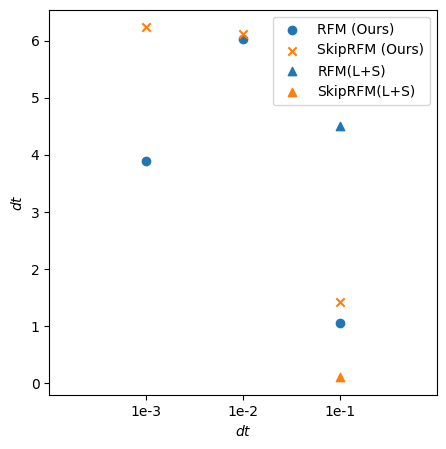

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
data_folder = "../data"

rfm_1 = pd.read_csv(f"{data_folder}/L63/config_7/RFM/D_r-200_B-1/batch_data.csv")
skip_rfm_1 = pd.read_csv(f"{data_folder}/L63/config_7/SkipRFM/D_r-200_B-1/batch_data.csv")

rfm_01 = pd.read_csv(f"{data_folder}/L63/config_4/RFM/D_r-200_B-1/batch_data.csv")
skip_rfm_01 = pd.read_csv(f"{data_folder}/L63/config_4/SkipRFM/D_r-200_B-1/batch_data.csv")

rfm_001 = pd.read_csv(f"{data_folder}/L63/config_6/RFM/D_r-200_B-1/batch_data.csv")
skip_rfm_001 = pd.read_csv(f"{data_folder}/L63/config_6/SkipRFM/D_r-200_B-1/batch_data.csv")

ax.scatter(3, rfm_1["tau_f_nmse"].mean(), label='RFM (Ours)', c='#1f77b4')
ax.scatter(3, skip_rfm_1["tau_f_nmse"].mean(), label='SkipRFM (Ours)', c='#ff7f0e', marker='x')
ax.scatter(2, rfm_01["tau_f_nmse"].mean(),  c='#1f77b4')
ax.scatter(2, skip_rfm_01["tau_f_nmse"].mean(),  c='#ff7f0e', marker='x')
ax.scatter(1, rfm_001["tau_f_nmse"].mean(),  c='#1f77b4')
ax.scatter(1, skip_rfm_001["tau_f_nmse"].mean(), c='#ff7f0e', marker='x')
ax.scatter(3, 4.5, label='RFM(L+S)', marker='^')
ax.scatter(3, 0.1, label='SkipRFM(L+S)', marker='^')
ax.legend(loc='upper right')
ax.set_xlabel(r'$dt$')
ax.set_ylabel(r'$dt$')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['1e-3', '1e-2', '1e-1'])
ax.set_xlim([0., 4.])